In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from typing import Dict, Tuple, List

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    # out = out.reshape(((huge_pages + 31) // 32, 32))
    return pd.DataFrame(out)

def load_data(max_mem: int, modes: Dict[str, Path]) -> Tuple[pd.DataFrame, List[Dict[str, int]]]:
    datas = []
    for mode, p in modes.items():
        data = pd.read_csv(p / "out_0.csv")
        data["mode"] = mode
        datas.append(data)

    data = pd.concat(datas)
    data["small"] = max_mem - data["small"] * 2**12
    data["huge"] = max_mem - data["huge"] * 2**(12+9)
    data["time"] = data.index
    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["rss", "small", "huge", "cached"])

    times = [json.load((p / "times_0.json").open()) for p in modes.values()]
    return data, times


def relplot(max_mem: int, data: pd.DataFrame, times: List[Dict[str, int]], run_label="build") -> sns.FacetGrid:
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", hue="measurement", height=6, legend=False)
    p.set_titles("{col_name}")
    p.set(ylabel="memory consumption (GiB)")
    p.set(xlabel="runtime (s)")
    p.set(ylim=(0, max_mem * 1.05))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])

    labels = data["measurement"].unique()
    legend = {
        label: Line2D(xdata=[], ydata=[], color=l.get_color(), linestyle=l.get_linestyle())
        for label, l in zip(labels, p.facet_axis(0, 0).get_lines())
    }

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        if isinstance(time["build"], list):
            tlast = 0
            for tbuild, tdelay in zip(time["build"], time["delay"]):
                p.facet_axis(0, i).axvspan(xmin=tlast, xmax=tbuild, edgecolor=sns.crayons["Gray"], facecolor="white", zorder=-1, hatch="//")
                tlast = tdelay
        else:
            p.facet_axis(0, i).axvspan(xmin=0, xmax=time["build"], edgecolor=sns.crayons["Gray"], facecolor="white", zorder=-1, hatch="//")
        tdelay = time["delay"][-1] if isinstance(time["delay"], list) else time["delay"]
        p.facet_axis(0, i).axvline(x=tdelay, color=sns.crayons["Violet (Purple)"], zorder=1)
        p.facet_axis(0, i).axvline(x=time["clean"], color="black", zorder=1)


    legend[""] = Patch(color="white")
    legend[run_label] = Patch(edgecolor=sns.crayons["Gray"], facecolor="white", hatch="//")
    legend["clean"] = Line2D(xdata=[], ydata=[], color=sns.crayons["Violet (Purple)"])
    legend["drop"] = Line2D(xdata=[], ydata=[], color="black")
    p.add_legend(legend)

    return p


def visualize(max_mem: int, modes: Dict[str, Path], run_label = "build") -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    return relplot(max_mem, data, times, run_label=run_label)


Matplotlib is building the font cache; this may take a moment.


## Linux

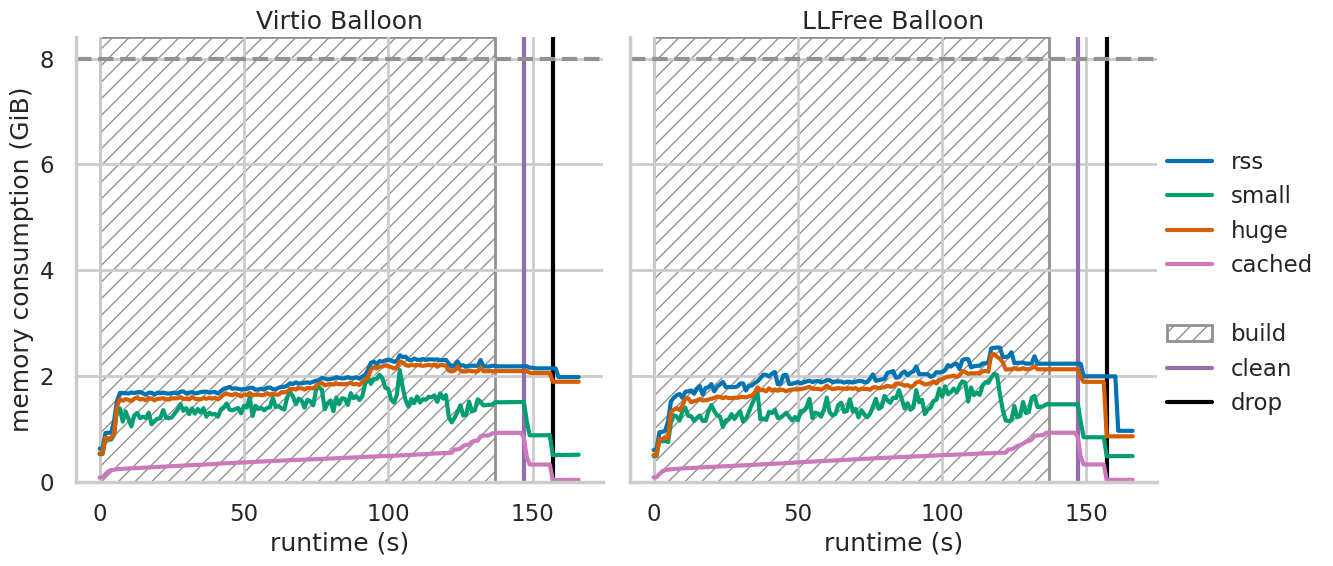

In [95]:
# Buddy, Free-Page-Reporting, 8G, 8C
max_mem = 8*1024**3
p = visualize(max_mem, {
    "Virtio Balloon": Path("compiling/240411-152344-linux-base-auto"),
    "LLFree Balloon": Path("compiling/240415-112323-linux-llfree-auto"),
})

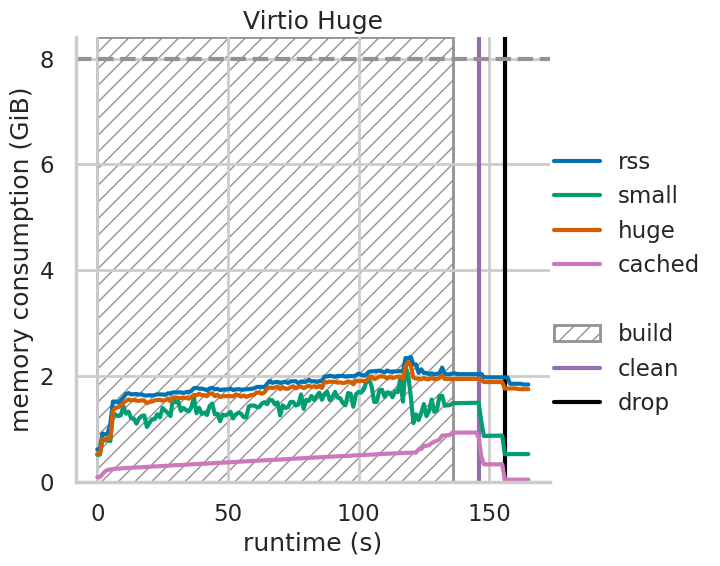

In [84]:
# Virtio Huge, Auto, 8G, 8C
max_mem = 8*1024**3
p = visualize(max_mem, {"Virtio Huge": Path("compiling/240411-145919-linux-huge-auto")})

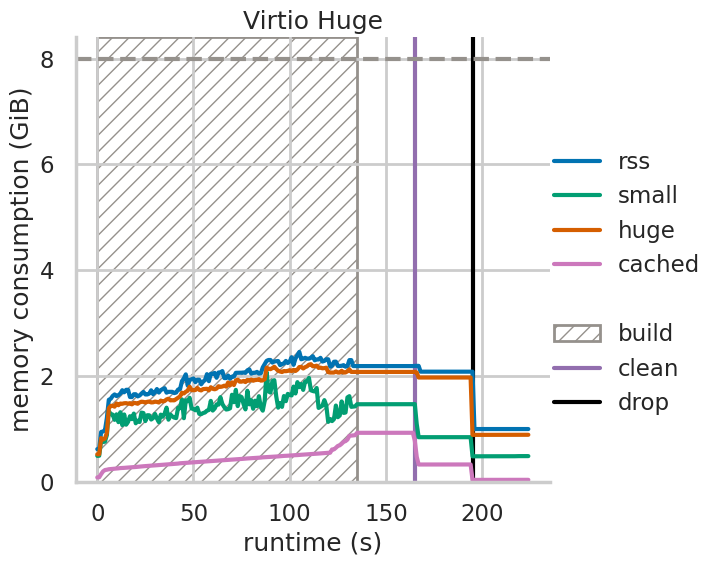

In [3]:
# Virtio Huge, Auto, 8G, 8C
max_mem = 8*1024**3
p = visualize(max_mem, {"Virtio Huge": Path("compiling/240422-223322-linux-llfree-auto")})

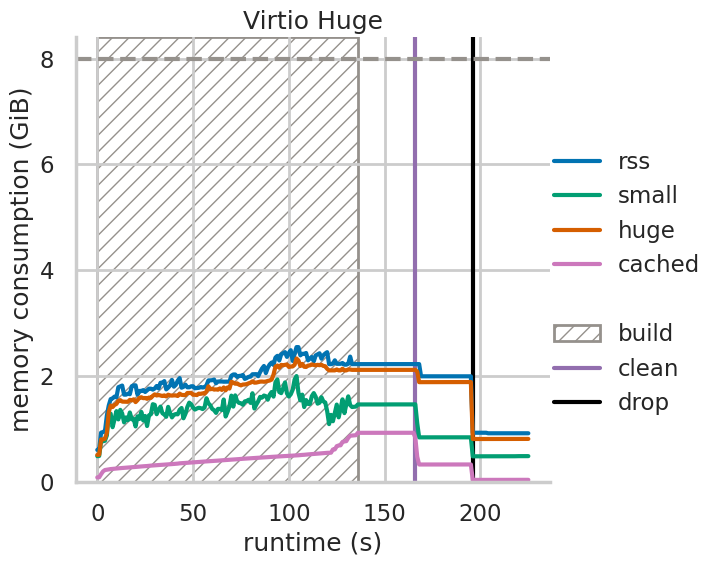

In [4]:
# Virtio Huge, Auto, 8G, 8C
max_mem = 8*1024**3
p = visualize(max_mem, {"Virtio Huge": Path("compiling/240423-010610-linux-llfree-auto")})

## Clang

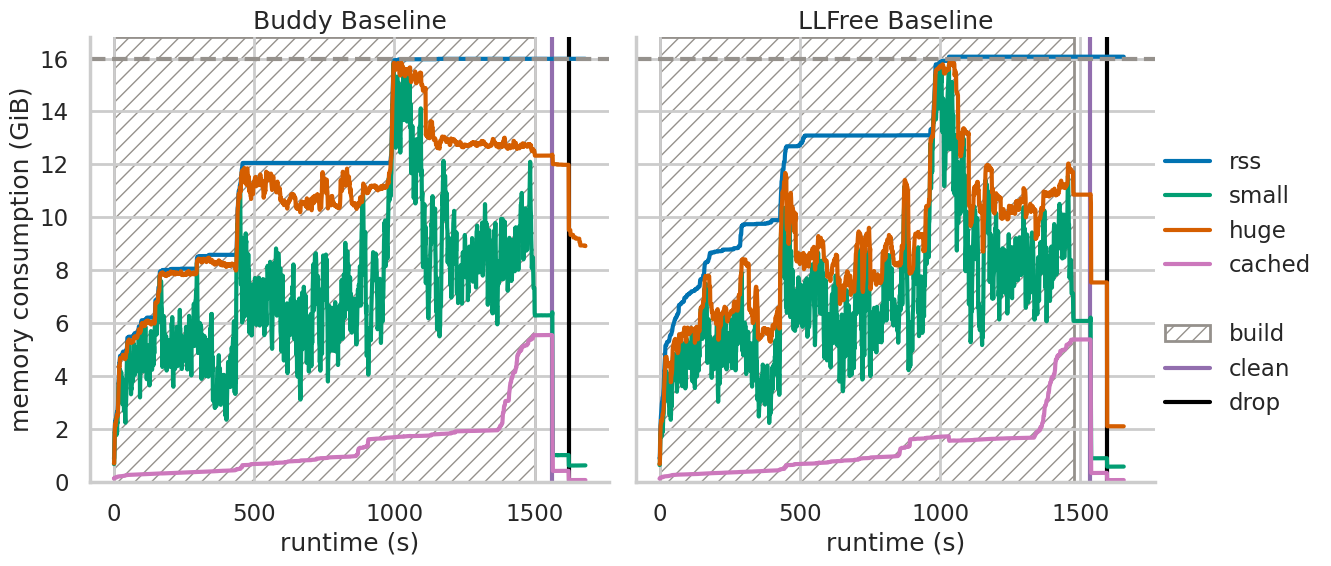

In [85]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy Baseline": Path("compiling/240416-165843-clang-base-manual"),
    "LLFree Baseline": Path("compiling/240416-190100-clang-llfree-manual"),
})

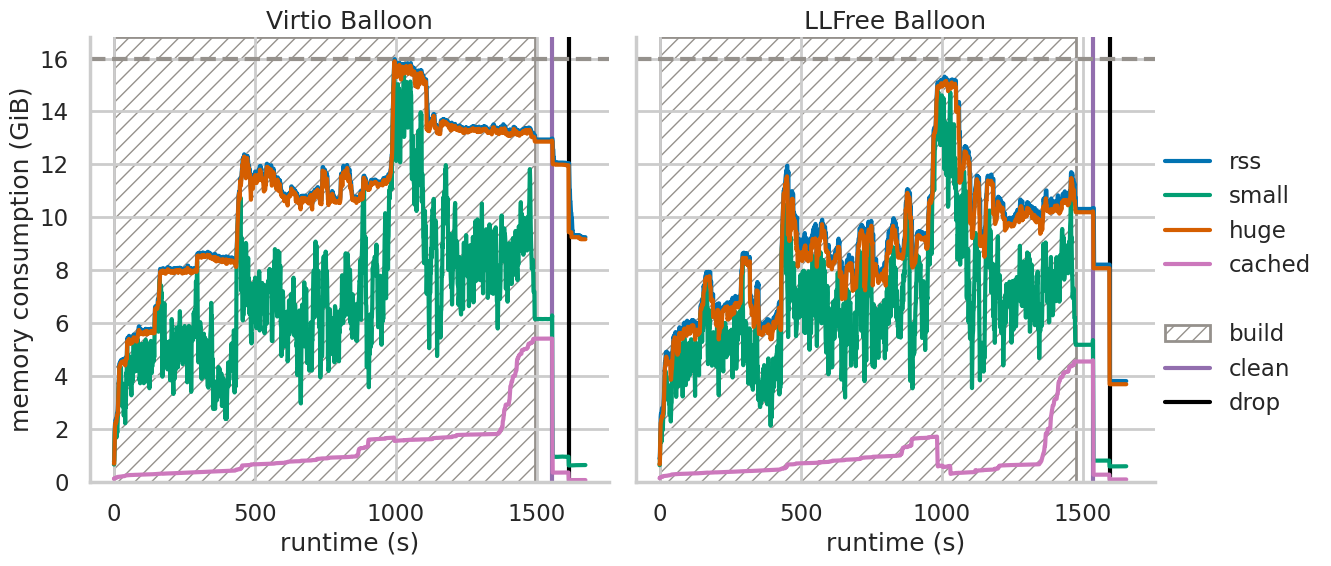

In [86]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Virtio Balloon": Path("compiling/240416-173939-clang-base-auto"),
    "LLFree Balloon": Path("compiling/240416-194111-clang-llfree-auto"),
})


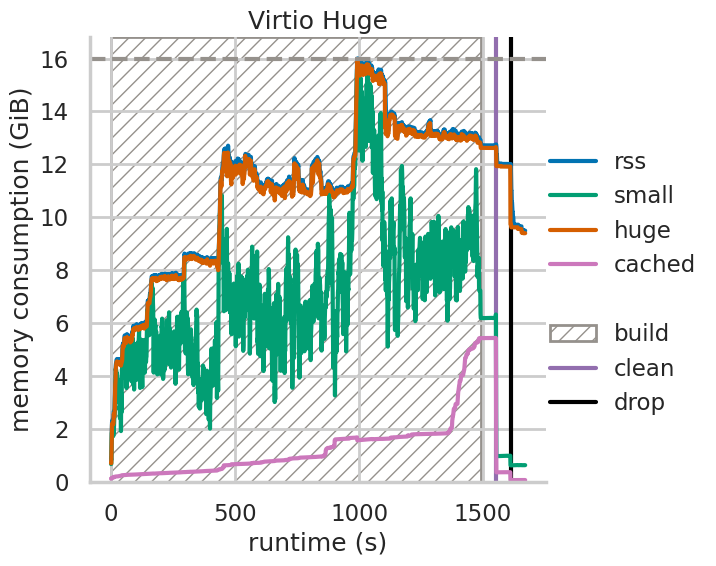

In [87]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Virtio Huge": Path("compiling/240416-182022-clang-huge-auto")
})


## SPEC17 Blender

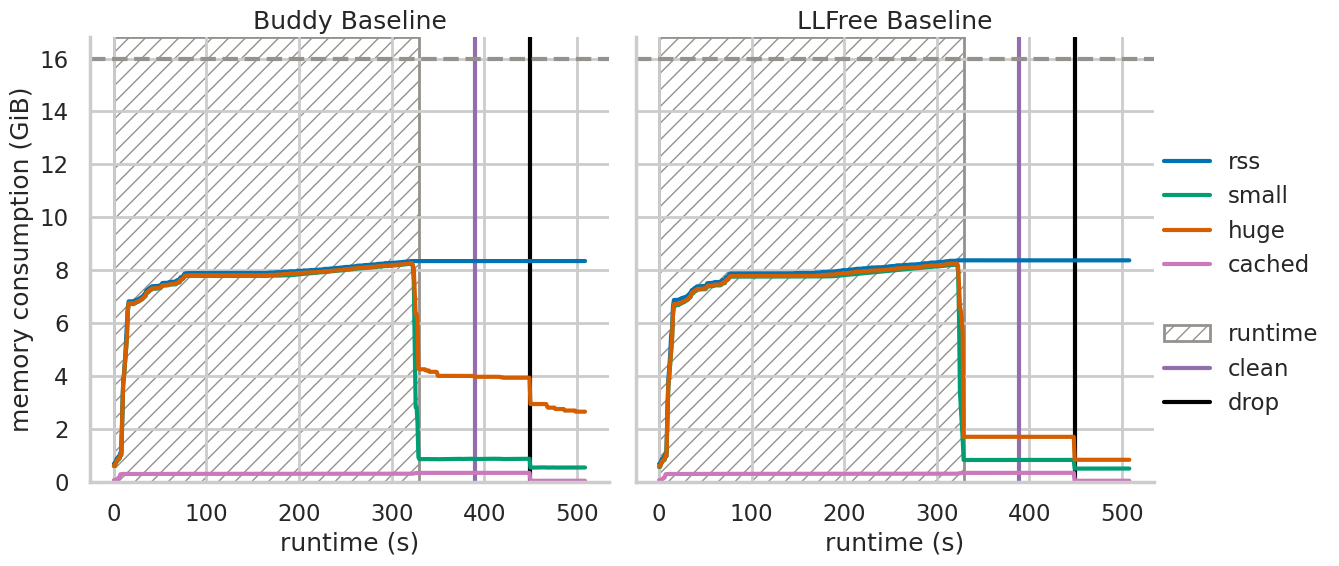

In [4]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy Baseline": Path("compiling/240416-202117-blender-base-manual"),
    "LLFree Baseline": Path("compiling/240416-205733-blender-llfree-manual"),
}, run_label="runtime")

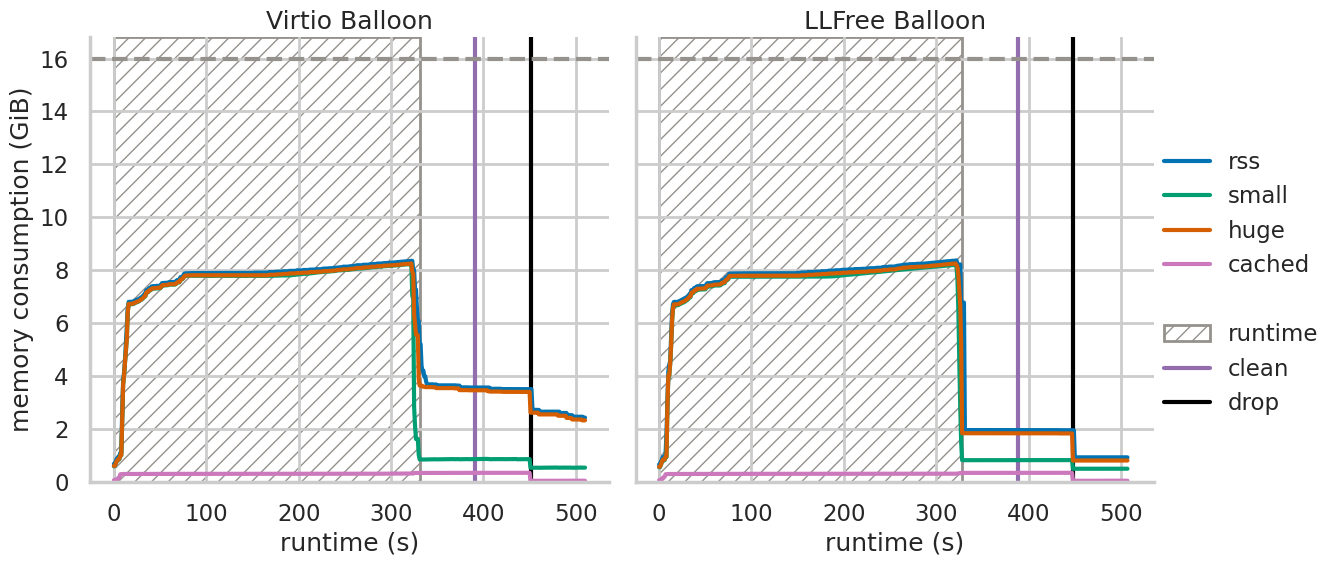

In [5]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Virtio Balloon": Path("compiling/240416-203322-blender-base-auto"),
    "LLFree Balloon": Path("compiling/240416-210936-blender-llfree-auto"),
}, run_label="runtime")

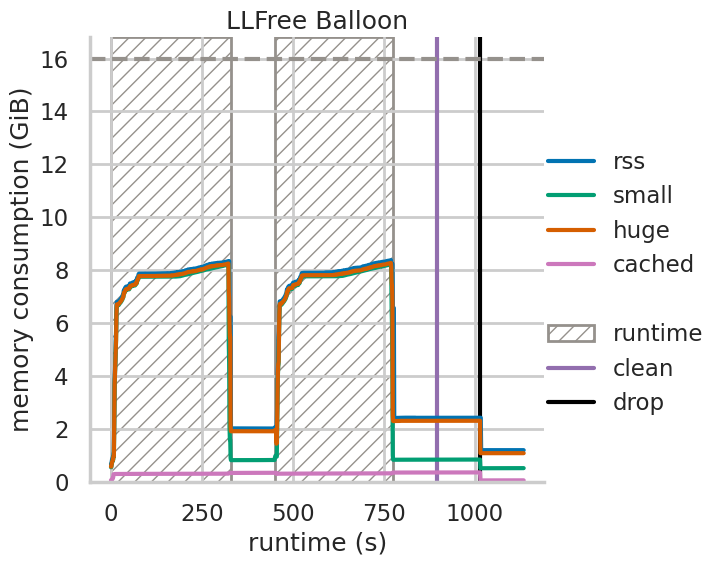

In [6]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "LLFree Balloon": Path("compiling/240418-110248-blender-llfree-auto"),
}, run_label="runtime")